In [52]:
%pip install opencv-python numpy matplotlib seaborn scikit-learn


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: C:\Users\LENOVO\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [53]:
import os
import cv2  # OpenCV
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Agar grafik muncul di notebook
%matplotlib inline

print("Library berhasil di-import!")

#end

Library berhasil di-import!


In [54]:
# --- KONFIGURASI ---
DATASET_PATH = "dataset wajah2" 
IMG_SIZE = 160  # resolusi gambar wajah

def load_dataset(path):
    data = []
    labels = []
    class_names = []
    
    # Cek folder
    if not os.path.exists(path):
        print(f"Error: Folder '{path}' tidak ditemukan!")
        print("Tips: Cek sidebar kiri VS Code, apa nama folder sebenarnya? (Huruf besar/kecil berpengaruh)")
        return np.array(data), np.array(labels), class_names

    print(f"Sedang memeriksa folder: {path} ...")

    for folder_name in os.listdir(path):
        folder_path = os.path.join(path, folder_name)

        if os.path.isdir(folder_path):
            class_names.append(folder_name)
            label_index = class_names.index(folder_name)
            print(f"--> Memproses kelas: {folder_name}")

            for img_name in os.listdir(folder_path):
                img_path = os.path.join(folder_path, img_name)
                try:
                    # 1. Baca Citra
                    img_array = cv2.imread(img_path)
                    if img_array is None: continue 

                    # 2. Grayscaling (Sesuai Laporan)
                    gray_img = cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY)

                    # 3. Resizing 
                    resized_img = cv2.resize(gray_img, (IMG_SIZE, IMG_SIZE))

                    data.append(resized_img)
                    labels.append(label_index)

                except Exception as e:
                    pass

    data = np.array(data)
    labels = np.array(labels)
    
    print(f"\nSelesai! Total Data: {len(data)} citra.")
    
    # Validasi output
    if len(data) > 0:
        print(f"Dimensi Citra: {data.shape[1]}x{data.shape[2]} (Sesuai Laporan)")
    
    return data, labels, class_names

# --- EKSEKUSI ---
data, labels, class_names = load_dataset(DATASET_PATH)

if len(data) > 0:
    print("Dataset siap digunakan untuk Training!")

Sedang memeriksa folder: dataset wajah2 ...
--> Memproses kelas: Brad Pitt
--> Memproses kelas: Camila Cabello
--> Memproses kelas: Claire Holt
--> Memproses kelas: Courtney Cox
--> Memproses kelas: Daffa Hermansyah
--> Memproses kelas: Ellen Degeneres
--> Memproses kelas: Farrel Erza Farandi
--> Memproses kelas: Jessica Alba
--> Memproses kelas: Maheswara Ariq Athallah
--> Memproses kelas: Muhammad Al Qarnie

Selesai! Total Data: 500 citra.
Dimensi Citra: 160x160 (Sesuai Laporan)
Dataset siap digunakan untuk Training!


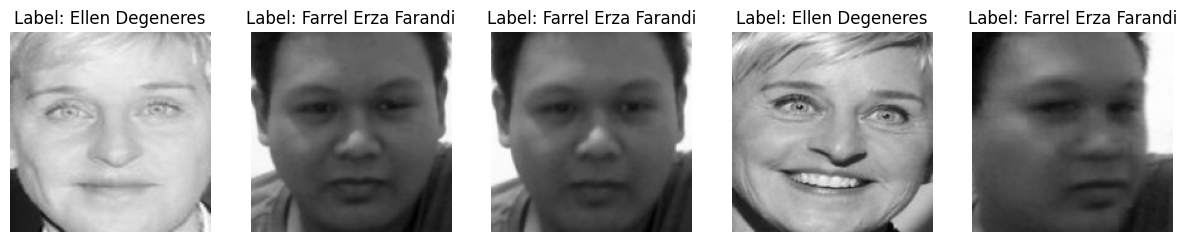

In [55]:
# Menampilkan 5 sampel acak
plt.figure(figsize=(15, 5))
for i in range(5):
    idx = np.random.randint(0, len(data))
    plt.subplot(1, 5, i+1)
    plt.imshow(data[idx], cmap='gray')
    plt.title(f"Label: {class_names[labels[idx]]}")
    plt.axis('off')
plt.show()

#end

In [56]:
# 1. Flattening
X = data.reshape(len(data), -1) 
y = labels

print(f"Dimensi Data Sebelum Flatten: {data.shape}")
print(f"Dimensi Data Setelah Flatten: {X.shape} (Siap untuk KNN)")

# 2. Split Data (80% Latih, 20% Uji)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Jumlah Data Latih: {len(X_train)}")
print(f"Jumlah Data Uji: {len(X_test)}")

#end

Dimensi Data Sebelum Flatten: (500, 160, 160)
Dimensi Data Setelah Flatten: (500, 25600) (Siap untuk KNN)
Jumlah Data Latih: 400
Jumlah Data Uji: 100


Mulai Pengujian Nilai K...
------------------------------
|  Nilai K  |  Akurasi (80:20)  |
------------------------------
|    K=1    |     90.00%     |
|    K=3    |     82.00%     |
|    K=5    |     83.00%     |
|    K=7    |     81.00%     |
|    K=9    |     84.00%     |
------------------------------


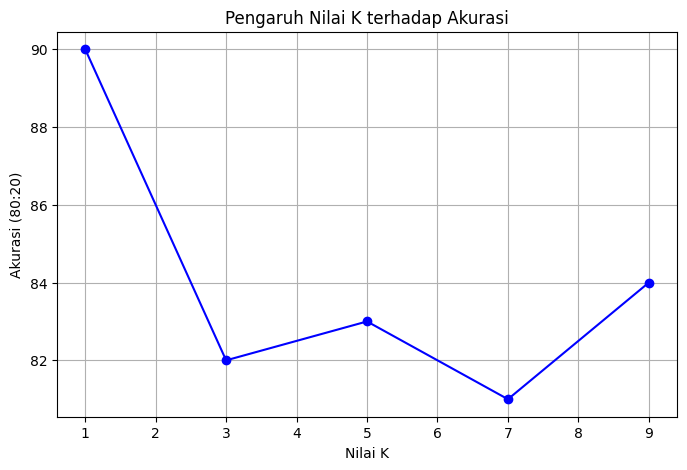

In [57]:
k_values = [1, 3, 5, 7, 9]
accuracies = []

print("Mulai Pengujian Nilai K...")
print("-" * 30)
print("|  Nilai K  |  Akurasi (80:20)  |")
print("-" * 30)

for k in k_values:
    # Membuat model KNN
    model = KNeighborsClassifier(n_neighbors=k, metric='euclidean')

    # Melatih model
    model.fit(X_train, y_train)

    # Prediksi
    y_pred = model.predict(X_test)

    # Hitung akurasi
    acc = accuracy_score(y_test, y_pred) * 100
    accuracies.append(acc)

    print(f"|    K={k}    |     {acc:.2f}%     |")

print("-" * 30)

# Visualisasi Grafik 
plt.figure(figsize=(8, 5))
plt.plot(k_values, accuracies, marker='o', linestyle='-', color='b')
plt.title('Pengaruh Nilai K terhadap Akurasi')
plt.xlabel('Nilai K')
plt.ylabel('Akurasi (80:20)')
plt.grid(True)
plt.show()


#end


--- Laporan Klasifikasi (K=1) ---
                         precision    recall  f1-score   support

              Brad Pitt       0.69      0.90      0.78        10
         Camila Cabello       1.00      0.70      0.82        10
            Claire Holt       0.91      1.00      0.95        10
           Courtney Cox       0.70      0.70      0.70        10
       Daffa Hermansyah       1.00      1.00      1.00        10
        Ellen Degeneres       0.89      0.80      0.84        10
    Farrel Erza Farandi       1.00      1.00      1.00        10
           Jessica Alba       0.90      0.90      0.90        10
Maheswara Ariq Athallah       1.00      1.00      1.00        10
     Muhammad Al Qarnie       1.00      1.00      1.00        10

               accuracy                           0.90       100
              macro avg       0.91      0.90      0.90       100
           weighted avg       0.91      0.90      0.90       100



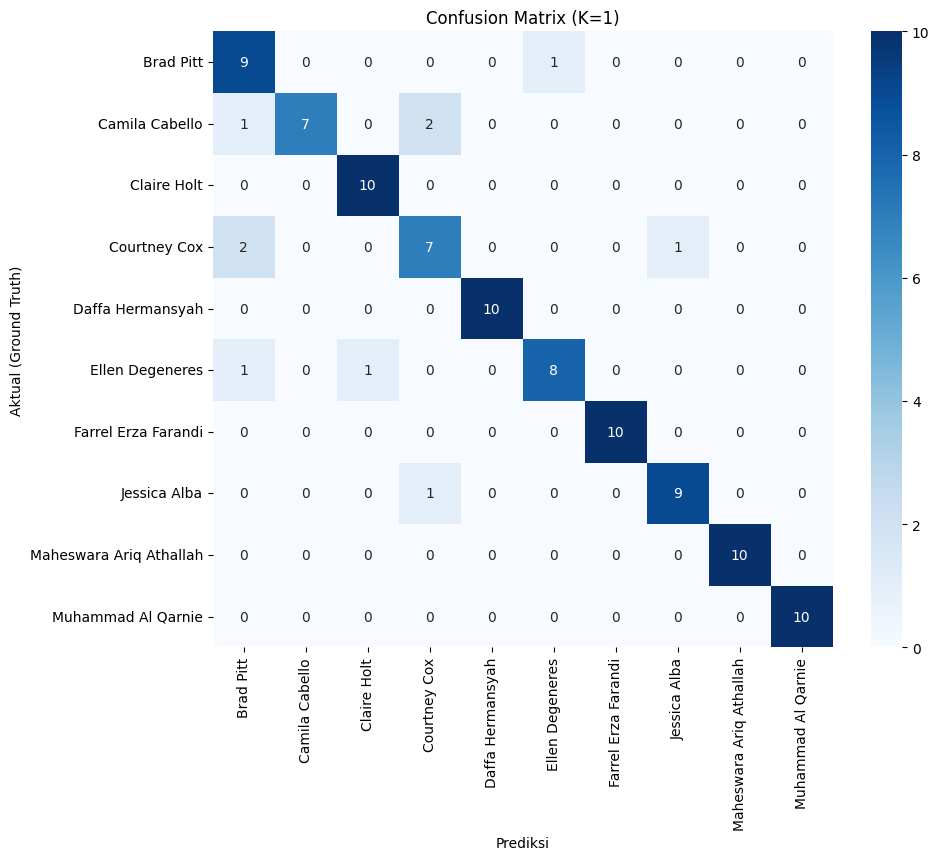

In [58]:
# Ambil K terbaik
BEST_K = 1
final_model = KNeighborsClassifier(n_neighbors=BEST_K, metric='euclidean')
final_model.fit(X_train, y_train)

# Prediksi Akhir
y_pred_final = final_model.predict(X_test)

# --- 1. Presisi, Recall, F1 ---
print(f"\n--- Laporan Klasifikasi (K={BEST_K}) ---")
print(classification_report(y_test, y_pred_final, target_names=class_names))

# --- 2. CONFUSION MATRIX ---
cm = confusion_matrix(y_test, y_pred_final)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Prediksi')
plt.ylabel('Aktual (Ground Truth)')
plt.title(f'Confusion Matrix (K={BEST_K})')
plt.show()

#end

Jarak terdekat: 2539.04
Sistem: Wajah Dikenali sebagai Farrel Erza Farandi


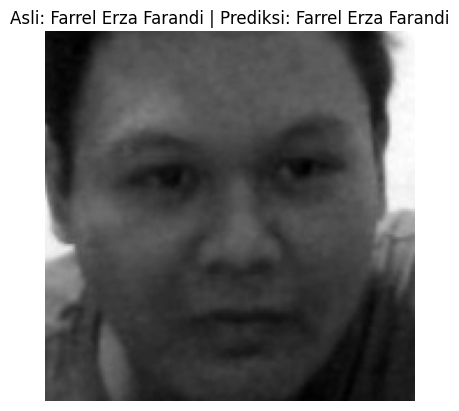

In [70]:
def simulasi_absensi(index_test):
    # Ambil satu gambar dari data uji
    img_test = X_test[index_test].reshape(1, -1) # Flatten ulang
    actual_label = class_names[y_test[index_test]]

    # Cari jarak ke tetangga terdekat 
    distances, indices = final_model.kneighbors(img_test)
    min_distance = distances[0][0] 

    # Tentukan Threshold 
    THRESHOLD = 10000 
    
    print(f"Jarak terdekat: {min_distance:.2f}")

    if min_distance > THRESHOLD:
        print("Sistem: Wajah TIDAK Dikenali (Jarak terlalu jauh)")
        pred_label = "Unknown"
    else:
        pred_index = final_model.predict(img_test)[0]
        pred_label = class_names[pred_index]
        print(f"Sistem: Wajah Dikenali sebagai {pred_label}")

    # Tampilkan Gambar
    plt.imshow(X_test[index_test].reshape(IMG_SIZE, IMG_SIZE), cmap='gray')
    plt.title(f"Asli: {actual_label} | Prediksi: {pred_label}")
    plt.axis('off')
    plt.show()

# Coba simulasi
simulasi_absensi(2)

#end

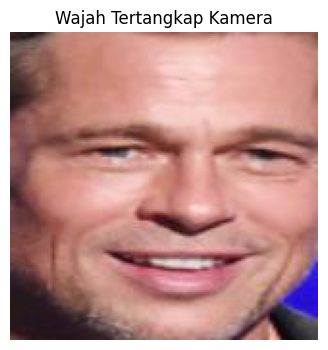


--- HASIL ANALISIS SISTEM ---
Jarak Kemiripan: 6041.10
🟢 Status: ABSEN BERHASIL!
👤 Identitas: Brad Pitt


In [60]:
# --- SIMULASI ABSENSI DENGAN FOTO EKSTERNAL ---

def tes_foto_baru(path_file_gambar):
    """
    Fungsi ini mensimulasikan kamera menangkap wajah seseorang.
    Kita ambil file gambar dari luar dataset, lalu suruh AI menebak.
    """
    
    # 1. Cek apakah file ada
    if not os.path.exists(path_file_gambar):
        print(f"Error: File '{path_file_gambar}' tidak ditemukan!")
        return

    # 2. Baca Gambar
    img_real = cv2.imread(path_file_gambar)
    if img_real is None:
        print("Error: Gambar tidak bisa dibaca.")
        return
    
    # Tampilkan Gambar Asli
    plt.figure(figsize=(4, 4))
    plt.imshow(cv2.cvtColor(img_real, cv2.COLOR_BGR2RGB))
    plt.title("Wajah Tertangkap Kamera")
    plt.axis('off')
    plt.show()

    try:
        # 3. Pra-pemrosesan
        # a. Grayscale
        gray_new = cv2.cvtColor(img_real, cv2.COLOR_BGR2GRAY)
        
        # b. Resize
        resized_new = cv2.resize(gray_new, (IMG_SIZE, IMG_SIZE))
        
        # c. Flatten
        flat_new = resized_new.reshape(1, -1)

        # 4. Prediksi (KNN)
        distances, indices = final_model.kneighbors(flat_new)
        min_dist = distances[0][0]
        
        # 5. Logika Absensi (toleransi)
        THRESHOLD_DEMO = 25000 
        
        print(f"\n--- HASIL ANALISIS SISTEM ---")
        print(f"Jarak Kemiripan: {min_dist:.2f}")
        
        if min_dist > THRESHOLD_DEMO:
            print("🔴 Status: WAJAH TIDAK DIKENALI (Orang Asing / Bukan Mahasiswa)")
        else:
            pred_index = final_model.predict(flat_new)[0]
            nama_prediksi = class_names[pred_index]
            print(f"🟢 Status: ABSEN BERHASIL!")
            print(f"👤 Identitas: {nama_prediksi}")
            
    except Exception as e:
        print(f"Terjadi kesalahan: {e}")

tes_foto_baru("Brad Pitt_118.jpg")


=== PENGUJIAN RASIO 70:30 ===
Data Latih: 350 citra
Data Uji  : 150 citra
----------------------------------------
|  Nilai K  |  Akurasi (70:30)  |
----------------------------------------
|    K=1    |     83.33%      |
|    K=3    |     79.33%      |
|    K=5    |     80.67%      |
|    K=7    |     80.67%      |
|    K=9    |     81.33%      |
----------------------------------------


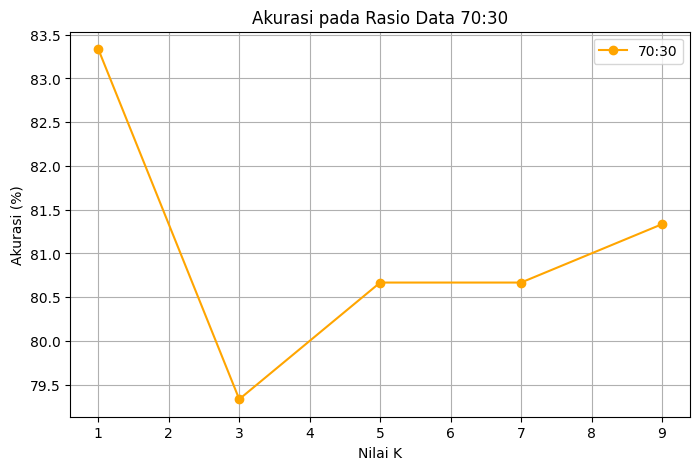

In [61]:
# --- SKENARIO 2.A: PENGUJIAN RASIO 70:30 ---
print("\n=== PENGUJIAN RASIO 70:30 ===")

# 1. Split Data (70% Latih, 30% Uji)
X_train_70, X_test_30, y_train_70, y_test_30 = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Data Latih: {len(X_train_70)} citra")
print(f"Data Uji  : {len(X_test_30)} citra")

k_values = [1, 3, 5, 7, 9]
accuracies_70 = [] # List untuk menyimpan nilai akurasi agar bisa di-plot

print("-" * 40)
print("|  Nilai K  |  Akurasi (70:30)  |")
print("-" * 40)

for k in k_values:
    model_70 = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
    model_70.fit(X_train_70, y_train_70)
    y_pred_70 = model_70.predict(X_test_30)
    
    # Hitung akurasi
    acc = accuracy_score(y_test_30, y_pred_70) * 100
    accuracies_70.append(acc) # Simpan ke list

    print(f"|    K={k}    |     {acc:.2f}%      |")
print("-" * 40)

# --- VISUALISASI GRAFIK 70:30 ---
plt.figure(figsize=(8, 5))
plt.plot(k_values, accuracies_70, marker='o', linestyle='-', color='orange', label='70:30')
plt.title('Akurasi pada Rasio Data 70:30')
plt.xlabel('Nilai K')
plt.ylabel('Akurasi (%)')
plt.grid(True)
plt.legend()
plt.show()


=== PENGUJIAN RASIO 90:10 ===
Data Latih: 450 citra
Data Uji  : 50 citra
----------------------------------------
|  Nilai K  |  Akurasi (90:10)  |
----------------------------------------
|    K=1    |     88.00%      |
|    K=3    |     80.00%      |
|    K=5    |     84.00%      |
|    K=7    |     82.00%      |
|    K=9    |     82.00%      |
----------------------------------------


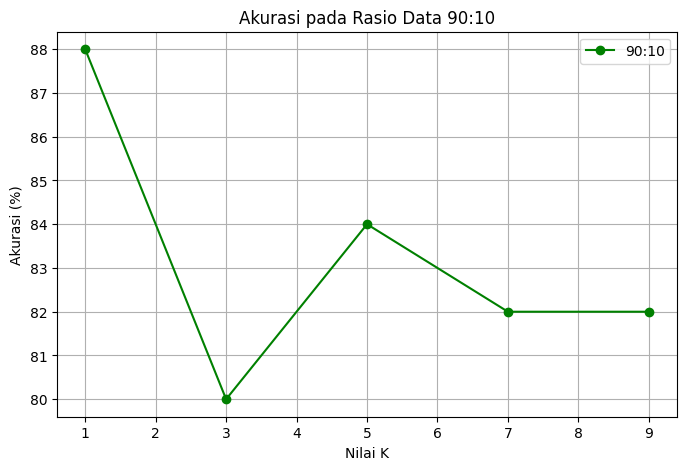

In [62]:
# --- SKENARIO 2.B: PENGUJIAN RASIO 90:10 ---
print("\n=== PENGUJIAN RASIO 90:10 ===")

# 1. Split Data (90% Latih, 10% Uji)
X_train_90, X_test_10, y_train_90, y_test_10 = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)

print(f"Data Latih: {len(X_train_90)} citra")
print(f"Data Uji  : {len(X_test_10)} citra")

k_values = [1, 3, 5, 7, 9]
accuracies_90 = [] # List wajib ada untuk grafik

print("-" * 40)
print("|  Nilai K  |  Akurasi (90:10)  |")
print("-" * 40)

for k in k_values:
    model_90 = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
    model_90.fit(X_train_90, y_train_90)
    y_pred_90 = model_90.predict(X_test_10)
    
    # Hitung akurasi
    acc = accuracy_score(y_test_10, y_pred_90) * 100
    accuracies_90.append(acc) # Simpan ke list

    print(f"|    K={k}    |     {acc:.2f}%      |")
print("-" * 40)

# --- VISUALISASI GRAFIK 90:10 ---
plt.figure(figsize=(8, 5))
plt.plot(k_values, accuracies_90, marker='o', linestyle='-', color='green', label='90:10')
plt.title('Akurasi pada Rasio Data 90:10')
plt.xlabel('Nilai K')
plt.ylabel('Akurasi (%)')
plt.grid(True)
plt.legend()
plt.show()

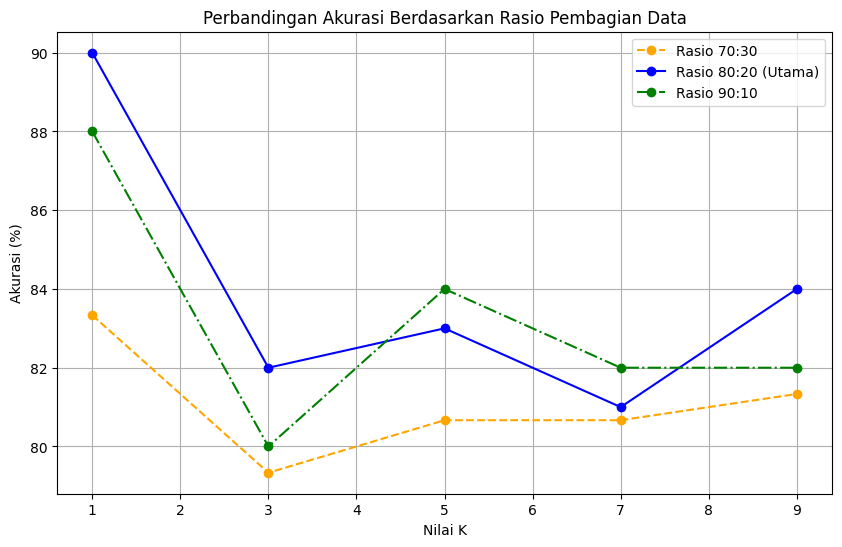

In [63]:
##Perbandingan antara ketiga grafik pengujian

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.plot(k_values, accuracies_70, marker='o', linestyle='--', color='orange', label='Rasio 70:30')
plt.plot(k_values, accuracies,    marker='o', linestyle='-',  color='blue',   label='Rasio 80:20 (Utama)')
plt.plot(k_values, accuracies_90, marker='o', linestyle='-.', color='green',  label='Rasio 90:10')

plt.title('Perbandingan Akurasi Berdasarkan Rasio Pembagian Data')
plt.xlabel('Nilai K')
plt.ylabel('Akurasi (%)')
plt.grid(True)
plt.legend()
plt.show()

In [68]:
import cv2
import pandas as pd
from datetime import datetime
import os
import time  

# Konfigurasi Waktu
DURASI_VALIDASI = 5  # Detik wajah harus stabil agar terabsen

# Load Detektor
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def absen_dengan_validasi_waktu():
    print(f"Membuka Kamera... Fitur Validasi {DURASI_VALIDASI} Detik AKTIF.")
    print("Tekan 'q' untuk simpan & keluar.")
    
    cap = cv2.VideoCapture(0)
    
    # Variabel Penyimpanan
    nama_sudah_absen = set()
    data_absensi = []
    
    # Variabel untuk menyimpan 'Stopwatch' setiap orang
    wajah_timers = {} 

    tanggal_hari_ini = datetime.now().strftime("%Y-%m-%d")
    nama_file_csv = f"Absensi_{tanggal_hari_ini}.csv"

    while True:
        ret, frame = cap.read()
        if not ret: break

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.1, 5, minSize=(30, 30))

        # List nama yang terdeteksi di frame ini saja (untuk reset timer jika wajah hilang)
        nama_di_frame_ini = []

        for (x, y, w, h) in faces:
            wajah_crop = gray[y:y+h, x:x+w]
            
            try:
                # Resize & Prediksi
                wajah_resize = cv2.resize(wajah_crop, (IMG_SIZE, IMG_SIZE))
                wajah_flat = wajah_resize.reshape(1, -1)
                
                distances, indices = final_model.kneighbors(wajah_flat)
                min_dist = distances[0][0]
                
                # Threshold (Menyesuaikan)
                if min_dist > 6000:
                    nama = "Unknown"
                    warna = (0, 0, 255) # Merah
                else:
                    pred_idx = final_model.predict(wajah_flat)[0]
                    nama = class_names[pred_idx]
                    warna = (0, 255, 255) # Kuning (Proses Verifikasi)

                # --- LOGIKA VALIDASI 5 DETIK ---
                if nama != "Unknown":
                    nama_di_frame_ini.append(nama)
                    
                    # 1. Jika orang ini belum ada di timer, nyalakan stopwatch
                    if nama not in wajah_timers:
                        wajah_timers[nama] = time.time()
                    
                    # 2. Hitung sudah berapa lama wajah ini muncul
                    durasi_sekarang = time.time() - wajah_timers[nama]
                    sisa_waktu = DURASI_VALIDASI - durasi_sekarang
                    
                    # 3. Cek Status Absen
                    if nama in nama_sudah_absen:
                        # Jika sudah absen sebelumnya
                        pesan_status = "SUDAH ABSEN"
                        warna = (0, 255, 0) # Hijau Solid
                        bar_progress = 1.0 # Penuh
                        
                    elif durasi_sekarang >= DURASI_VALIDASI:
                        # Absen ketika wajah terdeteksi selama 5 detik
                        waktu_masuk = datetime.now().strftime("%H:%M:%S")
                        nama_sudah_absen.add(nama)
                        data_absensi.append({
                            'Nama': nama,
                            'Waktu Masuk': waktu_masuk,
                            'Status': 'Hadir (Terverifikasi)'
                        })
                        print(f"✅ [VALID] {nama} berhasil absen pukul {waktu_masuk}")
                        pesan_status = "BERHASIL!"
                        warna = (0, 255, 0) # Hijau
                        bar_progress = 1.0
                        
                    else:
                        # --- PROSES MENUNGGU (0 - 4.9 Detik) ---
                        pesan_status = f"Tahan... {sisa_waktu:.1f}s"
                        warna = (0, 255, 255) # Kuning
                        bar_progress = durasi_sekarang / DURASI_VALIDASI

                    # --- VISUALISASI ---
                    # Gambar Kotak Wajah
                    cv2.rectangle(frame, (x, y), (x+w, y+h), warna, 2)
                    
                    # Gambar Loading Bar di bawah kepala
                    bar_width = int(w * bar_progress)
                    cv2.rectangle(frame, (x, y-15), (x + bar_width, y-5), warna, -1) # Bar isi
                    cv2.rectangle(frame, (x, y-15), (x + w, y-5), (255, 255, 255), 1) # Border bar
                    
                    # Tulis Nama
                    cv2.putText(frame, f"{nama}", (x, y+h+25), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.7, warna, 2)
                    # Tulis Status (Tahan... / Berhasil)
                    cv2.putText(frame, pesan_status, (x, y+h+50), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
                
                else:
                    # Kondisi Unknown
                    cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 0, 255), 2)
                    cv2.putText(frame, "Unknown", (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)

            except Exception as e:
                pass

        # --- RESET TIMER JIKA WAJAH HILANG ---
        for nama_timer in list(wajah_timers.keys()):
            if nama_timer not in nama_di_frame_ini:
                # Kecuali kalau dia sudah absen, biarkan saja
                if nama_timer not in nama_sudah_absen:
                    del wajah_timers[nama_timer]
        
        # Info Layar
        cv2.putText(frame, f"Total Hadir: {len(nama_sudah_absen)}", (10, 30), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        cv2.imshow('Sistem Absensi + Validasi (Tekan q Keluar)', frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

    # Simpan CSV
    if len(data_absensi) > 0:
        df = pd.DataFrame(data_absensi)
        if os.path.exists(nama_file_csv):
            df.to_csv(nama_file_csv, mode='a', header=False, index=False)
        else:
            df.to_csv(nama_file_csv, index=False)
        print("\n--- Data Absensi Tersimpan ---")
        print(df)

# Jalankan
absen_dengan_validasi_waktu()

Membuka Kamera... Fitur Validasi 5 Detik AKTIF.
Tekan 'q' untuk simpan & keluar.
✅ [VALID] Muhammad Al Qarnie berhasil absen pukul 02:24:12

--- Data Absensi Tersimpan ---
                 Nama Waktu Masuk                 Status
0  Muhammad Al Qarnie    02:24:12  Hadir (Terverifikasi)


In [65]:
import cv2
import os
import time

# --- KONFIGURASI ---
DATASET_DIR = "dataset wajah2"  # Folder utama
IMG_SIZE = 160                  # Resolusi gambar
MAX_PHOTOS = 50                 # Target jumlah foto
JEDA_WAKTU = 0.5                # Jeda antar foto (detik)

# Load Detektor Wajah
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def ambil_foto_otomatis():
    # 1. Input Nama
    nama_user = input("Masukkan Nama Anda (untuk Label Folder): ").strip()
    
    # Buat folder
    save_path = os.path.join(DATASET_DIR, nama_user)
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    
    # 2. Buka Kamera
    cap = cv2.VideoCapture(0)
    
    print(f"\n--- MODE OTOMATIS AKTIF ---")
    print(f"Sistem akan mengambil foto setiap {JEDA_WAKTU} detik.")
    print("Silakan gerakkan wajah Anda perlahan (kiri, kanan, senyum).")
    print("Tekan 'q' jika ingin berhenti paksa.\n")
    
    # Beri waktu persiapan 3 detik sebelum mulai
    print("Mulai dalam 3...")
    time.sleep(1)
    print("2...")
    time.sleep(1)
    print("1...")
    time.sleep(1)
    print("MULAI!\n")
    
    count = 0
    waktu_terakhir_ambil = time.time()
    
    while count < MAX_PHOTOS:
        ret, frame = cap.read()
        if not ret: break
        
        display_frame = frame.copy()
        
        # Deteksi Wajah
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.1, 5, minSize=(30, 30))
        
        # Cek Waktu 
        waktu_sekarang = time.time()
        siap_ambil = (waktu_sekarang - waktu_terakhir_ambil) > JEDA_WAKTU
        
        for (x, y, w, h) in faces:
            # Gambar kotak
            if siap_ambil:
                warna = (0, 255, 0) # Hijau (Saat mengambil wajah)
            else:
                warna = (255, 0, 0) # Biru (Menunggu jeda)
                
            cv2.rectangle(display_frame, (x, y), (x+w, y+h), warna, 2)
            
            # --- LOGIKA SIMPAN OTOMATIS ---
            if siap_ambil:
                # Proses Gambar
                wajah_crop = gray[y:y+h, x:x+w]
                wajah_resize = cv2.resize(wajah_crop, (IMG_SIZE, IMG_SIZE))
                
                # Simpan
                filename = f"{nama_user}_{count+1}.jpg"
                file_path = os.path.join(save_path, filename)
                cv2.imwrite(file_path, wajah_resize)
                
                count += 1
                print(f"📸 Cekrek! ({count}/{MAX_PHOTOS})")
                
                # Reset waktu timer
                waktu_terakhir_ambil = time.time()
                
                # Efek visual di layar
                cv2.putText(display_frame, "SAVED!", (x, y-10), 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

        # Tampilkan Info 
        cv2.putText(display_frame, f"Progress: {count}/{MAX_PHOTOS}", (10, 50), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2)
        
        cv2.imshow("Auto Capture (q untuk stop)", display_frame)
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()
    
    if count >= MAX_PHOTOS:
        print(f"\n✅ SELESAI! 50 Foto wajah {nama_user} tersimpan.")
        print("Jangan lupa Run ulang bagian 'Load Dataset' & 'Training'!")

# Jalankan
ambil_foto_otomatis()


--- MODE OTOMATIS AKTIF ---
Sistem akan mengambil foto setiap 0.5 detik.
Silakan gerakkan wajah Anda perlahan (kiri, kanan, senyum).
Tekan 'q' jika ingin berhenti paksa.

Mulai dalam 3...
2...
1...
MULAI!

